[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://githubtocolab.com/alsinmr/pyRelaxSim/blob/master/GNMR2023/CEST.ipynb)

# Chemical Exchange Saturation Transfer (CEST)

In this notebook, we investigate the CEST experiment, first assuming only isotropic interactions (solution-state), and then also including influence from CSA.

In [1]:
# git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Build the spin system

In [3]:
ex0=RS.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-7)
ex1.set_inter(Type='CS',i=0,ppm=7)

## Build the Liouvillian
For CEST to work, we need to be able saturate the spins, which requires T2 relaxation. For a more realistic behavior, we also include T1 recovery of the magnetization, which can inhibit the saturation.

In [4]:
L=RS.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space

tc=1e-3     #Correlation time
p1=0.95  #Population of state 1
p2=1-p1  #Population of state 2

kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))   #Exchange matrix
L.kex=kex    #Add exchange to the Liouvillian

L.add_relax(Type='T1',i=0,T1=1.5,Peq=True)   #Add T1 relaxation to the system
L.add_relax(Type='T2',i=0,T2=.05)             #Add T2 relaxation to the system

## Calculate the required propagators
We'll simulate this system by starting with magnetization along the z-axis and saturating at some frequency. After the saturation period, we'll apply a $\pi/2$ pulse along the y-axis to get x-magnetization. This will be allowed to evolve, and Fourier transformed. We can then integrate the main peak to determine the amount of saturation that has occured.

In [5]:
Usat=list()   #We'll pre-calculate the propagators for saturation
voff0=np.linspace(-20,20,500)*ex0.v0[0]/1e6     #5 ppm*150 MHz / 1e6 =750 Hz
seq=L.Sequence()    #Makes a sequence, which lets us add pulses with user-specified timinig
for voff in voff0:
    seq.add_channel('13C',t=[0,.5],v1=25,voff=voff)  #500 ms saturation, 25 Hz strength
    Usat.append(seq.U())
    
seq=L.Sequence()   #Usually it's a better idea to re-initialize the sequence object for new pulses
seq.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=np.pi/2) 
Upi2=seq.U()     #Propagator to apply the pi/2 pulse
Dt=1/(4*10*150)  #For a 10 ppm shift difference, this should be enough to easily capture both peaks in the spectrum 
Uevol=L.U(Dt=Dt)  #Propagator for evolving the spin system

In [6]:
Usat[2].U['voff'].__class__

numpy.ndarray

## Run the sequence, with sweep over $\nu_1$
First, we generate the initial magnetization and the detection operator. Then, at each value of $\nu_1$, we reset the detection operator, followed by saturation (U taken out of Usat), apply the $\pi/2$ pulse (Upi2), and finally detect with Uevol. We store the Fourier-transformed signal in spec.

In [7]:
rho=RS.Rho(rho0='13Cz',detect='13Cp')
spec=list()
for U in Usat:
    rho.clear()
    Upi2*U*rho
    rho.DetProp(Uevol,n=1024)
    spec.append(rho.FT[0].real)

## Plot one of the spectra
In order to see the usefulness of this techique, we once plot the spectrum to show that the weaker peak is nearly invisible. We just take the last spectrum that is still stored in rho. The second peak is weakly visible if we zoom in around 5 ppm (but would be quite difficult to see in a real spectrum).

<IPython.core.display.Javascript object>


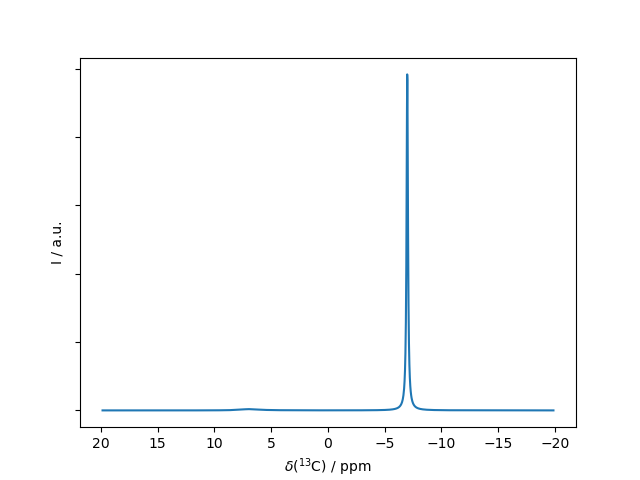

In [8]:
ax=rho.plot(FT=True,imag=False,axis='ppm')
_=ax.set_yticklabels('')

## Integrate spectrum for all values of $\nu_1$ and plot results
We will just integrate over the strong peak

<IPython.core.display.Javascript object>


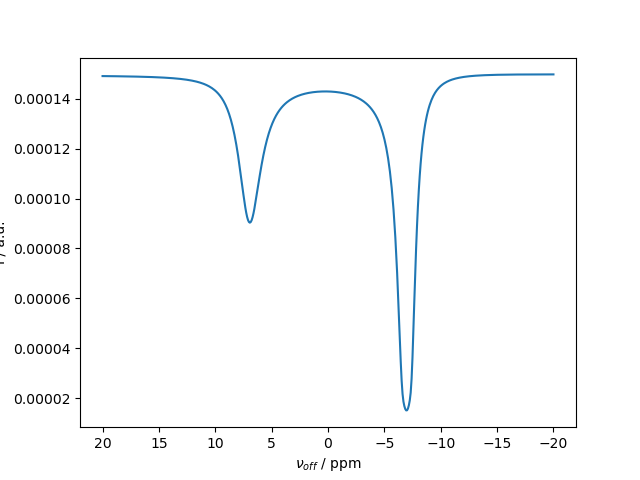

In [9]:
spec=np.array(spec)   #Convert to a numpy array
I=spec[:,400:620].sum(1)  #Integrate over the main peak

ax=plt.subplots()[1]
ax.plot(voff0*1e6/ex0.v0[0],I)
ax.set_xlabel(r'$\nu_{off}$ / ppm')
ax.set_ylabel('I / a.u.')
ax.invert_xaxis()

## Investigate CEST as a function of exchange rate
We repeat the above setup, just varying the exchange rates

In [10]:
p1=0.95  #Population of state 1
p2=1-p1  #Population of state 2

tc0=np.logspace(0,-5.5,12)
I=list()
for tc in tc0:
    kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))   #Exchange matrix
    L.kex=kex    #Add exchange to the Liouvillian
    
    Usat=list()   #We'll pre-calculate the propagators for saturation
    voff0=np.linspace(-20,20,500)*ex0.v0[0]/1e6     #5 ppm*150 MHz / 1e6 =750 Hz
    seq=L.Sequence()    #Makes a sequence, which lets us add pulses with user-specified timinig
    for voff in voff0:
        seq.add_channel('13C',t=[0,.5],v1=25,voff=voff)  #500 ms saturation, 25 Hz strength
        Usat.append(seq.U().calcU()) 
        #Propagtors do not automatically get calculated. In this case, 
        

    seq=L.Sequence()   #Usually it's a better idea to re-initialize the sequence object for new pulses
    seq.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=np.pi/2) 
    Upi2=seq.U()     #Propagator to apply the pi/2 pulse
    Dt=1/(4*10*150)  #For a 10 ppm shift difference, this should be enough to easily capture both peaks in the spectrum 
    Uevol=L.U(Dt=Dt)  #Propagator for evolving the spin system

    rho=RS.Rho(rho0='13Cz',detect='13Cp')
    spec=list()
    for U in Usat:
        rho.clear()
        Upi2*U*rho
        rho.DetProp(Uevol,n=1024)
        spec.append(rho.FT[0].real)

    spec=np.array(spec)   #Convert to a numpy array
    I.append(spec[:,400:620].sum(1))  #Integrate over the main peak

Plot the results

<IPython.core.display.Javascript object>


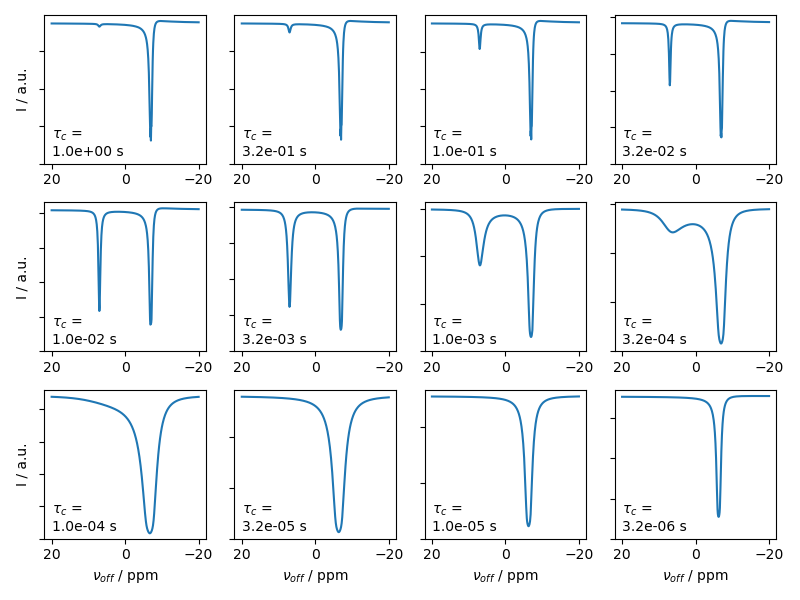

In [11]:
fig,ax=plt.subplots(3,4)
ax=ax.reshape(ax.size)

for a,I0,tc in zip(ax,I,tc0):
    a.plot(voff0*1e6/ex0.v0[0],I0)
    if a.get_subplotspec().is_last_row():
        a.set_xlabel(r'$\nu_{off}$ / ppm')
    if a.get_subplotspec().is_first_col():
        a.set_ylabel('I / a.u.')
    a.invert_xaxis()
    a.set_yticklabels('')
    a.set_ylim([0,a.get_ylim()[1]])
    a.text(20,a.get_ylim()[1]*.05,r'$\tau_c$'+f' = \n{tc:.1e} s')
fig.set_size_inches([8,6])
fig.tight_layout()

## Does coalescence occur for the same correlation time in CEST as in 1D spectra?
We set up the same system, but just calculate a 1D spectrum

In [12]:
p1=0.95  #Population of state 1
p2=1-p1  #Population of state 2

tc0=np.logspace(0,-5.5,12)
spec=list()
for tc in tc0:
    kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))   #Exchange matrix
    L.kex=kex    #Add exchange to the Liouvillian
    Uevol=L.U(Dt=Dt)  #Propagator for evolving the spin system

    rho=RS.Rho(rho0='13Cx',detect='13Cp')
    rho.DetProp(Uevol,n=1024)
    spec.append(rho.FT[0].real)

Plot the results

<IPython.core.display.Javascript object>


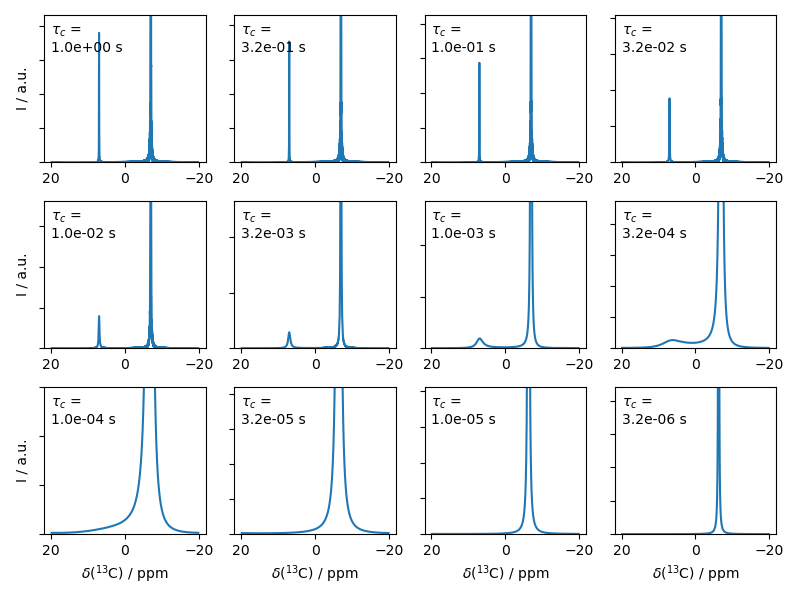

In [13]:
fig,ax=plt.subplots(3,4)
ax=ax.reshape(ax.size)

for a,spec0,tc in zip(ax,spec,tc0):
    a.plot(rho.v_axis*1e6/ex0.v0[0],spec0)
    if a.get_subplotspec().is_last_row():
        a.set_xlabel(r'$\delta (^{13}$C) / ppm')
    if a.get_subplotspec().is_first_col():
        a.set_ylabel('I / a.u.')
    a.invert_xaxis()
    a.set_yticklabels('')
    a.set_ylim([0,spec0.max()*p2/p1*1.1])
    a.text(20,a.get_ylim()[1]*.75,r'$\tau_c$'+f' = \n{tc:.1e} s')
fig.set_size_inches([8,6])
fig.tight_layout()

# What happens in solid-state NMR?
We start by building the same system, but we also include MAS and a CSA

In [14]:
ex0=RS.ExpSys(v0H=600,vr=5000,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-7)
ex1.set_inter(Type='CS',i=0,ppm=7)
ex0.set_inter(Type='CSA',i=0,delta=100)
ex1.set_inter(Type='CSA',i=0,delta=100,euler=[0,30*np.pi/180,0])

L=RS.Liouvillian((ex0,ex1))

tc=1e-3     #Correlation time
p1=0.95  #Population of state 1
p2=1-p1  #Population of state 2

kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))   #Exchange matrix
L.kex=kex    #Add exchange to the Liouvillian

## Calculate the required propagators

In [44]:
Usat=list()   #We'll pre-calculate the propagators for saturation
voff0=np.linspace(-30,30,100)*ex0.v0[0]/1e6     #5 ppm*150 MHz / 1e6 =750 Hz
seq=L.Sequence()    #Makes a sequence, which lets us add pulses with user-specified timinig
for voff in voff0:
    seq.add_channel('13C',t=[0,L.taur],v1=25,voff=voff)  #1 rotor period, 25 Hz strength
    L.reset_prop_time()  #Technically not necessary, but probably a good idea
    Usat.append(seq.U()**int(0.5/L.taur))   #Approximately 500 ms saturation (for 5 kHz, this is 2500 rotor periods)
    
seq=L.Sequence()   #Usually it's a better idea to re-initialize the sequence object for new pulses
seq.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=np.pi/2) 
Upi2=seq.U()     #Propagator to apply the pi/2 pulse
Dt=1/(4*10*150)  #For a 10 ppm shift difference, this should be enough to easily capture both peaks in the spectrum 

Uevol=L.U()  #Propagator for evolving the spin system (1 rotor period)
seq_evol=L.Sequence() #We'll use this to capture the spectrum including spinning side bands (not for CEST)
seq_evol.add_channel('13C',t=[0,L.taur/10])

## First, plot the 1D spectrum

<IPython.core.display.Javascript object>


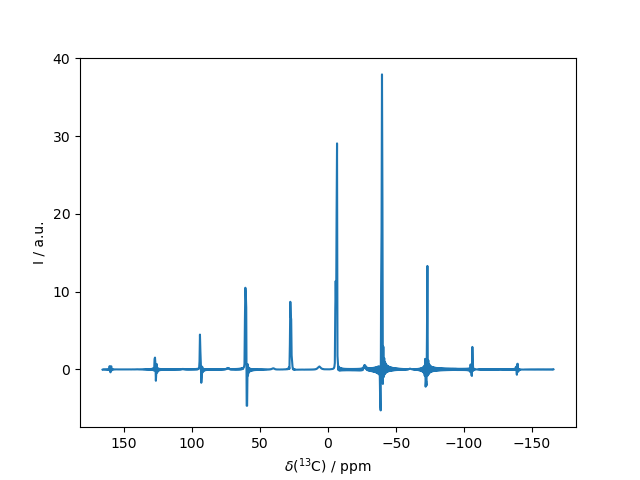

<AxesSubplot:xlabel='$\\delta$($^{13}$C) / ppm', ylabel='I / a.u.'>

In [45]:
rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(seq=seq_evol,n=512)
rho.plot(FT=True,imag=False,axis='ppm')

## Run the sequence with sweep over $\nu_1$

In [46]:
rho=RS.Rho(rho0='13Cz',detect='13Cp')
spec=list()
for U in Usat:
    rho.clear()
    Upi2*U*rho
    rho.DetProp(Uevol,n=1024)
    spec.append(rho.FT[0].real)

## Integrate spectrum for all values of $\nu_1$ and plot results
We will just integrate over the strong peak

<IPython.core.display.Javascript object>


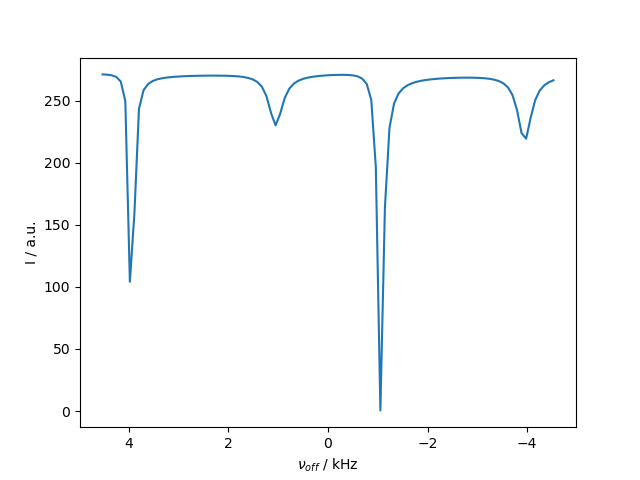

In [48]:
spec=np.array(spec)   #Convert to a numpy array
I=spec[:,400:620].sum(1)  #Integrate over the main peak

ax=plt.subplots()[1]
ax.plot(voff0/1e3,I)
ax.set_xlabel(r'$\nu_{off}$ / kHz')
ax.set_ylabel('I / a.u.')
ax.invert_xaxis()

The resulting spectrum has more dips than expected. What has happened is relatively simple– we've saturated the spinning side bands. The larger peak at 4 kHz is the side band of the main peak at -1 kHz, and the peak at -4 kHz is the side band of the low-populated state at 1 kHz. A broader sweep would reveal the full pattern of sidebands from the above spectrum. A simple solution for the sidebands exists: just spin faster.